# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE): 
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$ 
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$ 
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

### Installing necessary libraries

In [1]:
import os
import time
import numpy as np
from tqdm import trange
import torch.nn as nn
import h5py
import torch 
from torchsummary import summary
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1234)
device = 'cuda'
dtype = torch.float32
current_workspace = os.getcwd()

### Creating and importing the data

In [2]:
def get_train_data():
    with h5py.File(os.path.join(current_workspace, 'Datasets', 'EffectiveConductivity.h5')) as data:
        # Train data
        k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
        T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)

        # Test data 
        k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
        T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)

        # The coordinates
        x1 = np.array(data['X'])
        x2 = np.array(data['Y'])
    
    n_train = k_train.shape[0]
    n_test = k_test.shape[0]

    a_train = k_train.reshape(n_train, -1)
    u_train = T_train.reshape(n_train, -1)

    a_test = k_test.reshape(n_test, -1)
    u_test = T_test.reshape(n_test, -1)

    mesh = np.vstack([x1.ravel(), x2.ravel()]).T
    gridx = mesh.reshape(-1, 2)
    x = torch.tensor(gridx, dtype=dtype)
    
    return a_train, u_train, a_test, u_test, x, x1, x2

In [3]:
def plot_case(a_show, u_show, X, Y):

    a_show_grid = a_show.view(36, 36).numpy()
    u_show_grid = u_show.view(36, 36).numpy()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    cntr0 = axs[0].imshow(a_show_grid, origin='lower')
    fig.colorbar(cntr0, ax=axs[0])
    axs[0].set_title('True k')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_aspect('equal')

    cntr1 = axs[1].contourf(X, Y, u_show_grid, levels=40, cmap='jet')
    fig.colorbar(cntr1, ax=axs[1])
    axs[1].set_title('True T')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

In [4]:
class MyDataset(Dataset):
    def __init__(self, a:torch.tensor, u:torch.tensor):
        '''
        Input:
            a: size(batch_size, a_size)
            u: size(batch_size, u_size)
        '''
        self.a = a 
        self.u = u
    
    def __getitem__(self, index):
        return self.a[index], self.u[index]

    def __len__(self):
        return self.a.shape[0]

### Building the arquitecture of the DeepONet

In [5]:
class DeepONet(nn.Module):
    
    def __init__(self, layers_trunk, layers_branch, branch_type=None):
        super(DeepONet, self).__init__()
        # The trunk network
        self.activation_trunk = nn.ReLU()
        self.trunk_net(layers_trunk)
        
        # The branch network
        self.activation_branch = nn.ReLU()
        if branch_type=='cnn':
            self.branch_net_cnn(layers_branch)
        else:
            self.branch_net_mlp(layers_branch)
            
        # The bias term
        self.bias = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype))

    def branch_net_mlp(self, layers_branch):
        '''The branch network (MLP network)'''
        # Network Sequential
        net = []
        hidden_in = layers_branch[0]
        for hidden in layers_branch[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in = hidden
        self.branch = nn.Sequential(*net)

    def branch_net_cnn(self, layers_barnch):
        '''The branch network (CNN network)'''
        # Network Sequential
        net = []
        hidden_in = layers_barnch[0]
        for hidden in layers_barnch[1:]:
            net.append(nn.Conv2d(hidden_in, hidden, kernel_size=(5,5), 
                                 stride=2, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in =  hidden 
        self.branch = nn.Sequential(*net)
        
    def trunk_net(self, layers_trunk):
        '''The trunk network'''
        # Network Sequential
        net = []
        hidden_in = layers_trunk[0]
        for hidden in layers_trunk[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_trunk)
            hidden_in = hidden
        self.trunk = nn.Sequential(*net)
        
    def forward(self, x, a):
        ''' 
        Input:
            x: size(mesh_size, x_size)
            a: size(batch_size, a_size)
        '''
        # size(mesh_size, x_size) -> size(mesh_size, p)
        t = self.trunk(x)
        # size(batch_size, a_size) -> size(batch_size, p)
        b = self.branch(a)
        #
        output = torch.einsum("bp,mp->bm", b, t) + self.bias
        return output


### Defining the loss class of a supervised model

In [6]:
class LossClass(object):

    def __init__(self, u_model, x):
        self.device = device
        self.u_model = u_model 
        self.x = x.to(self.device)
        # self.getLoss = torch.nn.MSELoss()
    
    def loss_data(self, a_batch, u_batch):
        '''loss term'''
        a, u = a_batch.to(self.device), u_batch.to(self.device)
        #
        u_pred = self.u_model(self.x, a)
        loss = torch.norm(u-u_pred, 2, 1)
        loss = torch.mean(loss)
        # loss = self.getLoss(u, u_pred)
        return loss
    
    def error(self, a, u):
        '''error term'''
        a, u = a.to(self.device), u.to(self.device)
        u_pred = self.u_model(self.x, a)
        err = torch.mean(torch.sqrt(torch.sum((u_pred - u)**2, dim=1)/torch.sum(u**2, dim=1)))
        return err 

### Creating a Trainer Class for DeepONet

In [7]:
class SolverDeepONet:
    def __init__(self, x, a_train, u_train, a_test, u_test, model, LossClass, Optimizer, Scheduler, hiperparms, device):
        self.t0 = time.time()
        self.device = device 
        
        # hiperparameters
        self.layers_trunk = hiperparms['layers_trunk']
        self.layers_branch = hiperparms['layers_branch']
        self.epochs = hiperparms['epochs']
        self.batch_size = hiperparms['batch_size']
        self.patience = hiperparms['patience']
        self.lr = hiperparms['lr']
        self.weight_decay = hiperparms['weight_decay']
        self.step_size = self.epochs // hiperparms['step_size_divider']
        self.gamma = hiperparms['gamma']

        # creating instances of necessary classes
        self.model_u = model(self.layers_trunk, self.layers_branch).to(device)
        self.train_loader = DataLoader(MyDataset(a_train, u_train), batch_size=self.batch_size, shuffle=True)
        self.lossClass = LossClass(self.model_u, x.to(self.device))
        self.optimizer = Optimizer(params=self.model_u.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.scheduler = Scheduler(self.optimizer, step_size=self.step_size, gamma=self.gamma)

        # moving test set to device
        self.a_test, self.u_test = a_test.to(self.device), u_test.to(self.device)

        # initializing variables 
        self.loss_train_final = 0.
        self.loss_test_final = 0.
        self.error_test_final = 0.

        self.best_err_test = 1e10
        self.loss_train_list = []
        self.loss_test_list = []
        self.error_test_list = []

    def train(self):
        for epoch in trange(self.epochs):
            loss_train = 0.
            for a_batch, u_batch in self.train_loader:
                a_batch, u_batch = a_batch.to(device), u_batch.to(device)
                loss = self.lossClass.loss_data(a_batch, u_batch)
                #
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                #
                loss_train += loss
            loss_train = loss_train/len(self.train_loader)
            self.loss_train_list.append(loss_train.item())

            ## Test loss and error
            with torch.no_grad():
                loss_test = self.lossClass.loss_data(self.a_test, self.u_test)
                l2_test = self.lossClass.error(self.a_test, self.u_test)
            self.loss_test_list.append(loss_test.item())
            self.error_test_list.append(l2_test.item())
            
            ## Scheduler
            self.scheduler.step() 
            
            ## Saving best model
            if l2_test.item() < self.best_err_test:
                self.best_err_test = l2_test.item()
                epochs_no_improve = 0

                self.best_model_params = self.model_u.state_dict()
                self.error_test_final = l2_test.item()
                self.loss_test_final = loss_train.item()
                self.loss_test_final = loss_test.item()
            else:
                epochs_no_improve += 1

            ## Show progress
            if (epoch + 1) % 100 == 0 or epoch == 0:
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"[{epoch+1}/{self.epochs}] Train Loss: {loss_train.item():.6f} | Test Loss: {loss_test.item():.6f} | Rel L2: {l2_test.item():.6f} | LR: {current_lr:.2e}")

            # Early stopping
            if epochs_no_improve >= self.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
            
        print('The consuming time is:', time.time()-self.t0)
    
    def plot_training_results(self, save=False):
        if save: 
            os.makedirs('Results', exist_ok=True)
            os.makedirs('Results/Problem_B', exist_ok=True)

        # Subplot 1: Train & Test Loss
        plt.figure(figsize=(6, 4))
        plt.semilogy(self.loss_train_list, label='Train Loss')
        plt.semilogy(self.loss_test_list, label='Test Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss (log scale)")
        plt.title("Train vs Test Loss")
        plt.legend()
        if save: plt.savefig("Results/Problem_B/loss.png", pad_inches=0, transparent=True, dpi=300)
        plt.show()

        # Subplot 2: Test Relative Error
        plt.figure(figsize=(6, 4))
        plt.semilogy(self.error_test_list, label='Test Rel L2 Error', color='red')
        plt.xlabel("Epoch")
        plt.ylabel("Relative L2 Error (log scale)")
        plt.title("Test Relative L2 Error")
        if save: plt.savefig("Results/Problem_B/l2_error.png", pad_inches=0, transparent=True, dpi=300)
        plt.show()
    
    def save_best_model(self, name='Best_model_B'):
        os.makedirs('Models', exist_ok=True)
        if self.best_model_params:
            torch.save(self.best_model_params, f"Models/{name}.pth")

In [8]:
def plot_results(hiperparms, case_indx, model_path='Models/Best_Model_B.pth', save=False):
    if save: 
        os.makedirs('Results', exist_ok=True)
        os.makedirs('Results/Problem_B', exist_ok=True)
    _, _, a_test, u_test, x, X, Y = get_train_data()

    model_trained = DeepONet(hiperparms['layers_trunk'], hiperparms['layers_branch']).to(device)  
    model_trained.load_state_dict(torch.load(model_path, weights_only=True))

    lossClass = LossClass(model_trained, x)

    #########################################
    l2_error = lossClass.error(a_test, u_test)
    print('The test l2 error in the test whole dataset:', l2_error.item())

    l2_error_case = lossClass.error(a_test[0].reshape(1,-1), u_test[0].reshape(1,-1))
    print(f'The test l2 error in the test case {case_indx}:', l2_error_case.item())


    with torch.no_grad():
        u_pred = model_trained(x.to(device), a_test.to(device))
        u_pred = u_pred.detach().cpu()
    
    u_test, u_pred = u_test[case_indx].squeeze(0), u_pred[case_indx].squeeze(0)
    

    ny, nx = X.shape

    u_truth_grid = u_test.view(ny, nx).numpy()
    u_pred_grid = u_pred.view(ny, nx).numpy()
    diff_grid = u_truth_grid - u_pred_grid


    # True T
    plt.figure(figsize=(6, 5))  
    cntr0 = plt.contourf(X, Y, u_truth_grid, levels=40, cmap='jet')
    plt.colorbar(cntr0) 
    plt.title('True T')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')  
    if save: plt.savefig("Results/Problem_B/True_T.png", pad_inches=0, transparent=True, dpi=300)
    plt.show()

    # Pred T
    plt.figure(figsize=(6, 5))
    cntr1 = plt.contourf(X, Y, u_pred_grid, levels=40, cmap='jet')
    plt.colorbar(cntr1)
    plt.title('Pred T')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    if save: plt.savefig("Results/Problem_B/Pred_T.png", pad_inches=0, transparent=True, dpi=300)
    plt.show()

    # Difference
    plt.figure(figsize=(6, 5))
    cntr2 = plt.contourf(X, Y, diff_grid, levels=40, cmap='seismic')
    plt.colorbar(cntr2)
    plt.title('Difference (Truth - Pred)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    if save: plt.savefig("Results/Problem_B/Pointwise_abs_error.png", pad_inches=0, transparent=True, dpi=300)
    plt.show()

### Solving the problem

#### Showing the data

The shape of X: torch.Size([1296, 2])
The shape of k_train: torch.Size([1000, 1296])
The shape of T_train: torch.Size([1000, 1296])
The shape of k_test: torch.Size([200, 1296])
The shape of T_test: torch.Size([200, 1296])


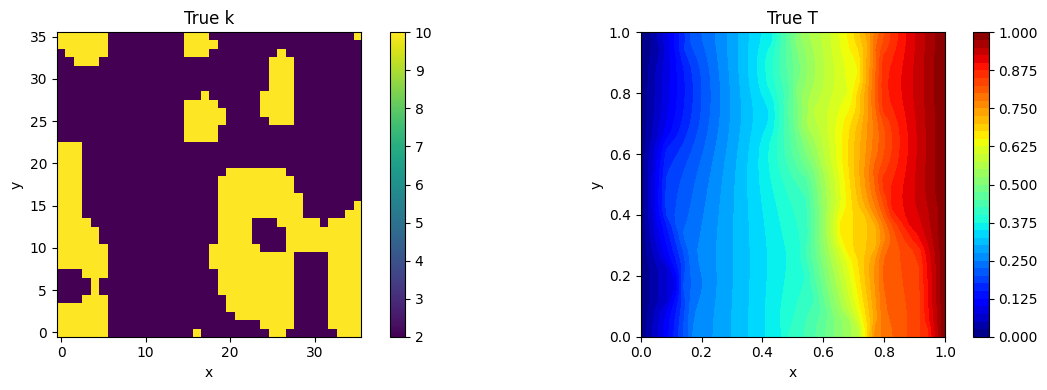

In [9]:
# Get training data
a_train, u_train, a_test, u_test, x, X, Y = get_train_data()
print('The shape of X:', x.shape)
print('The shape of k_train:', a_train.shape)
print('The shape of T_train:', u_train.shape)
print('The shape of k_test:', a_test.shape)
print('The shape of T_test:', u_test.shape)

# Plot one case
a_show, u_show = a_test[0], u_test[0]
plot_case(a_show, u_show, X, Y)

#### Training the model


In [10]:
# Define hiperparameters
hiperparms = {'layers_branch': [1296, 256, 256, 128], 'layers_trunk': [2, 256, 256, 128], 
              'epochs':3000, 'batch_size':50, 'patience':200, 'lr': 2e-4, 'weight_decay': 1e-3, 'step_size_divider': 4, 'gamma': 0.8}

In [11]:
# Get solver and train
solver = SolverDeepONet(x, a_train, u_train, a_test, u_test, DeepONet, LossClass, torch.optim.Adam, torch.optim.lr_scheduler.StepLR, hiperparms, device)
solver.train()

  0%|          | 3/3000 [00:00<07:42,  6.47it/s]

[1/3000] Train Loss: 5.948627 | Test Loss: 2.649033 | Rel L2: 0.126619 | LR: 2.00e-04


  3%|▎         | 101/3000 [00:08<04:04, 11.83it/s]

[100/3000] Train Loss: 0.800875 | Test Loss: 1.242902 | Rel L2: 0.059227 | LR: 2.00e-04


  7%|▋         | 201/3000 [00:17<03:52, 12.05it/s]

[200/3000] Train Loss: 0.675028 | Test Loss: 1.205357 | Rel L2: 0.057499 | LR: 2.00e-04


 10%|█         | 301/3000 [00:25<03:44, 12.00it/s]

[300/3000] Train Loss: 0.619892 | Test Loss: 1.138456 | Rel L2: 0.054308 | LR: 2.00e-04


 13%|█▎        | 401/3000 [00:33<03:36, 12.03it/s]

[400/3000] Train Loss: 0.650652 | Test Loss: 1.163747 | Rel L2: 0.055567 | LR: 2.00e-04


 17%|█▋        | 501/3000 [00:42<03:33, 11.68it/s]

[500/3000] Train Loss: 0.578512 | Test Loss: 1.128882 | Rel L2: 0.053812 | LR: 2.00e-04


 20%|██        | 601/3000 [00:50<03:21, 11.93it/s]

[600/3000] Train Loss: 0.543007 | Test Loss: 1.164682 | Rel L2: 0.055674 | LR: 2.00e-04


 23%|██▎       | 701/3000 [00:58<03:10, 12.04it/s]

[700/3000] Train Loss: 0.499840 | Test Loss: 1.099499 | Rel L2: 0.052412 | LR: 2.00e-04


 27%|██▋       | 801/3000 [01:07<03:02, 12.08it/s]

[800/3000] Train Loss: 0.459231 | Test Loss: 1.086911 | Rel L2: 0.051829 | LR: 1.60e-04


 30%|███       | 901/3000 [01:16<02:54, 12.02it/s]

[900/3000] Train Loss: 0.435170 | Test Loss: 1.096752 | Rel L2: 0.052336 | LR: 1.60e-04


 33%|███▎      | 1001/3000 [01:24<02:50, 11.69it/s]

[1000/3000] Train Loss: 0.465125 | Test Loss: 1.078369 | Rel L2: 0.051409 | LR: 1.60e-04


 37%|███▋      | 1101/3000 [01:32<02:38, 11.95it/s]

[1100/3000] Train Loss: 0.421807 | Test Loss: 1.074967 | Rel L2: 0.051288 | LR: 1.60e-04


 40%|████      | 1201/3000 [01:41<02:30, 11.92it/s]

[1200/3000] Train Loss: 0.465824 | Test Loss: 1.083504 | Rel L2: 0.051676 | LR: 1.60e-04


 43%|████▎     | 1302/3000 [01:50<02:20, 12.08it/s]

[1300/3000] Train Loss: 0.446980 | Test Loss: 1.091492 | Rel L2: 0.051961 | LR: 1.60e-04


 47%|████▋     | 1402/3000 [01:59<02:13, 11.97it/s]

[1400/3000] Train Loss: 0.422977 | Test Loss: 1.061028 | Rel L2: 0.050559 | LR: 1.60e-04


 50%|█████     | 1502/3000 [02:07<02:13, 11.22it/s]

[1500/3000] Train Loss: 0.410923 | Test Loss: 1.065171 | Rel L2: 0.050734 | LR: 1.28e-04


 53%|█████▎    | 1602/3000 [02:16<02:00, 11.58it/s]

[1600/3000] Train Loss: 0.386302 | Test Loss: 1.053712 | Rel L2: 0.050231 | LR: 1.28e-04


 57%|█████▋    | 1701/3000 [02:25<01:55, 11.27it/s]

[1700/3000] Train Loss: 0.411339 | Test Loss: 1.073739 | Rel L2: 0.051125 | LR: 1.28e-04


 60%|██████    | 1801/3000 [02:34<01:54, 10.48it/s]

[1800/3000] Train Loss: 0.379470 | Test Loss: 1.052798 | Rel L2: 0.050192 | LR: 1.28e-04


 63%|██████▎   | 1901/3000 [02:43<01:36, 11.40it/s]

[1900/3000] Train Loss: 0.381358 | Test Loss: 1.039614 | Rel L2: 0.049564 | LR: 1.28e-04


 67%|██████▋   | 2001/3000 [02:52<01:36, 10.38it/s]

[2000/3000] Train Loss: 0.362148 | Test Loss: 1.049374 | Rel L2: 0.050026 | LR: 1.28e-04


 70%|███████   | 2102/3000 [03:01<01:16, 11.78it/s]

[2100/3000] Train Loss: 0.365155 | Test Loss: 1.051912 | Rel L2: 0.050177 | LR: 1.28e-04


 73%|███████▎  | 2202/3000 [03:10<01:10, 11.33it/s]

[2200/3000] Train Loss: 0.356452 | Test Loss: 1.036160 | Rel L2: 0.049411 | LR: 1.28e-04


 77%|███████▋  | 2302/3000 [03:18<01:01, 11.28it/s]

[2300/3000] Train Loss: 0.344185 | Test Loss: 1.035632 | Rel L2: 0.049381 | LR: 1.02e-04


 80%|████████  | 2401/3000 [03:27<01:03,  9.38it/s]

[2400/3000] Train Loss: 0.343158 | Test Loss: 1.036900 | Rel L2: 0.049450 | LR: 1.02e-04


 83%|████████▎ | 2501/3000 [03:36<00:42, 11.71it/s]

[2500/3000] Train Loss: 0.346231 | Test Loss: 1.036513 | Rel L2: 0.049438 | LR: 1.02e-04


 87%|████████▋ | 2601/3000 [03:45<00:36, 10.96it/s]

[2600/3000] Train Loss: 0.349853 | Test Loss: 1.029992 | Rel L2: 0.049132 | LR: 1.02e-04


 90%|█████████ | 2701/3000 [03:54<00:25, 11.52it/s]

[2700/3000] Train Loss: 0.365723 | Test Loss: 1.038925 | Rel L2: 0.049542 | LR: 1.02e-04


 93%|█████████▎| 2801/3000 [04:03<00:21,  9.43it/s]

[2800/3000] Train Loss: 0.356920 | Test Loss: 1.027234 | Rel L2: 0.048997 | LR: 1.02e-04


 97%|█████████▋| 2901/3000 [04:12<00:08, 11.39it/s]

[2900/3000] Train Loss: 0.339684 | Test Loss: 1.031980 | Rel L2: 0.049224 | LR: 1.02e-04


100%|██████████| 3000/3000 [04:20<00:00, 11.51it/s]

[3000/3000] Train Loss: 0.336783 | Test Loss: 1.029295 | Rel L2: 0.049093 | LR: 8.19e-05
The consuming time is: 261.8975176811218


#### Plotting the training results

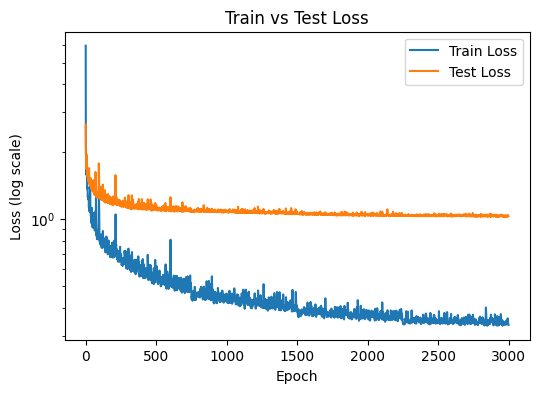

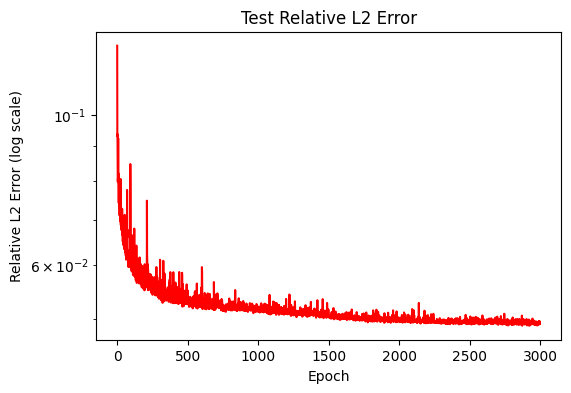

In [12]:
solver.plot_training_results(save=True)

#### Saving the model

In [13]:
solver.save_best_model()


#### Plotting the resutls

The test l2 error in the test whole dataset: 0.04909297823905945
The test l2 error in the test case 0: 0.08003855496644974


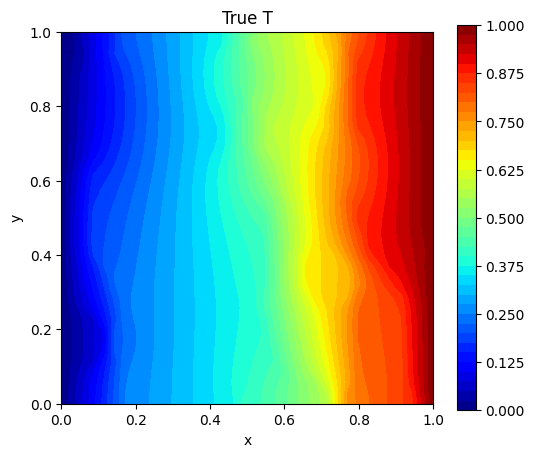

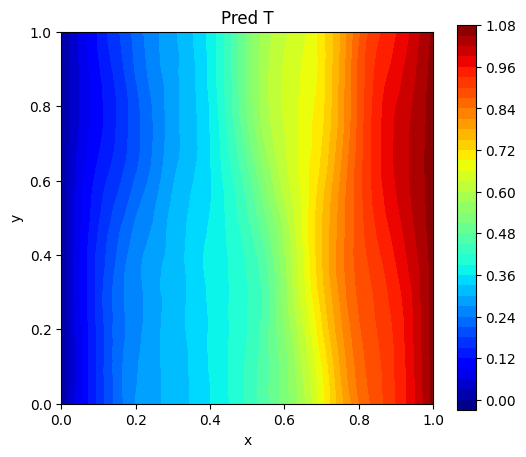

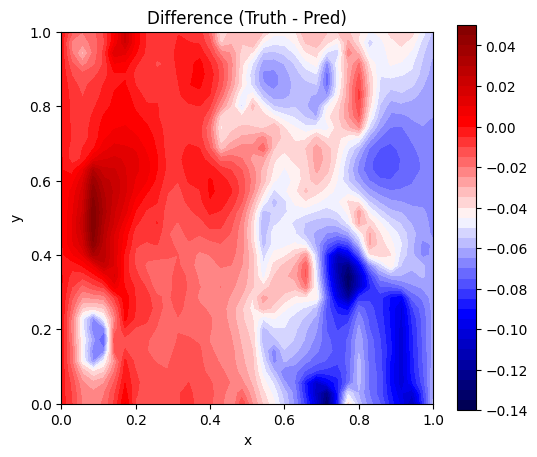

In [14]:
plot_results(hiperparms, case_indx=0, save=True)